In [1]:
from core import ContextModel
from metrics import (
    SquaredError, 
    
    FunctionClassError, 
    FCErrorQuadrants,
    FCErrorOrthogonal,
    FCErrorSeenPoints,
)
from metrics.utils import post_process
from function_classes.wrappers import (
    ScaledXRegression,
    ScaledYRegression,
    NoisyXRegression,
    NoisyYRegression,
)

from models import (
    LeastSquaresModel,
    ZeroModel,
)

from interactive import load_checkpoint_with_config

from function_classes.linear import LinearRegression

import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from typing import Optional
import torch

/opt/conda/envs/in-context-learning/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_model_errs(models: list[ContextModel], errors: list[torch.Tensor], plot_deviation: bool = True):
    information = list(post_process(errors))
    for model, info in zip(models, information):

        plt.plot('accuracy', data=info, lw=2, label=f"{model}")

        if plot_deviation:
            plt.fill_between( 
                list(range(info['accuracy'].shape[0])),
                info["confidence_0.01_upper"][..., 0],
                info["confidence_0.01_lower"][..., 0],
                data=info, alpha=0.2, linewidth=0, antialiased=True 
            )

    plt.xlabel("# in-context examples")
    plt.ylabel("squared error")

In [3]:
NUM_BATCHES, B_SIZE, SEQ_LEN, X_DIM, Y_DIM = 2, 32, 40, 20, 1
X_SHAPE = torch.Size([B_SIZE, SEQ_LEN, X_DIM])
Y_SHAPE = torch.Size([B_SIZE, SEQ_LEN, Y_DIM])

TRAIN_CONFIG = "../conf/train/linear_gpt2.yml"
CHECKPOINT_PATH = "../checkpoint_500000"

MODELS = [
    LeastSquaresModel(x_dim=X_DIM, y_dim=Y_DIM), 
    ZeroModel(x_dim=X_DIM, y_dim=Y_DIM),
    load_checkpoint_with_config(TRAIN_CONFIG, CHECKPOINT_PATH)
]

SCALES: list[float] = [0.125, 0.25, 0.5, 2., 4., 8.]
NOISE_LEVELS: list[float] = [0.0625, 0.125, 0.25, 0.5, 1.]

METRIC = SquaredError()

In [4]:
x_dist = MultivariateNormal(torch.zeros(X_SHAPE), torch.eye(X_DIM)) #batch size, sequence_length, x_dim

base_fc = LinearRegression(x_dist, y_dim=Y_DIM)

bench = FunctionClassError(METRIC, function_class=base_fc)

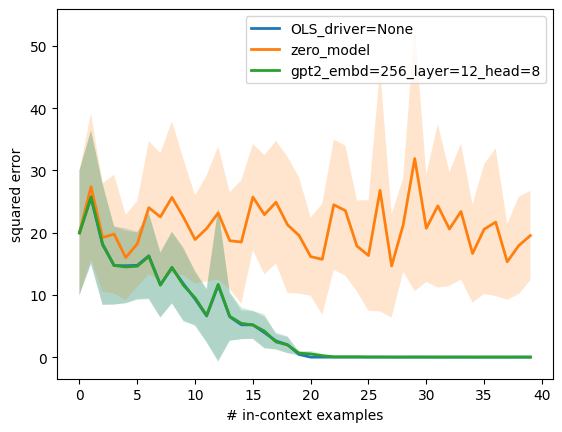

In [5]:
errs = bench.evaluate(MODELS, num_batches=NUM_BATCHES)
plot_model_errs(MODELS, errs)
plt.legend()

In [6]:
scaled_x_fcs = [
    ScaledXRegression(scale, base_fc)
    for scale in SCALES
]
scaled_in_benches = [FunctionClassError(METRIC, function_class=fc) for fc in scaled_x_fcs]

scaled_y_fcs = [
    ScaledYRegression(scale, base_fc)
    for scale in SCALES
]
scaled_out_benches = [FunctionClassError(METRIC, function_class=fc) for fc in scaled_y_fcs]

noisy_x_fcs = [
    NoisyXRegression(
        MultivariateNormal(
            torch.zeros(X_SHAPE), 
            noise_level * torch.eye(X_DIM)
        ),
        base_fc 
    )
    for noise_level in NOISE_LEVELS
]
noise_in_benches = [FunctionClassError(METRIC, function_class=fc) for fc in noisy_x_fcs]

noisy_y_fcs = [
    NoisyYRegression(
        MultivariateNormal(
            torch.zeros(Y_SHAPE), 
            noise_level * torch.eye(Y_DIM)
        ),
        base_fc 
    )
    for noise_level in NOISE_LEVELS
]
noise_out_benches = [FunctionClassError(METRIC, function_class=fc) for fc in noisy_y_fcs]

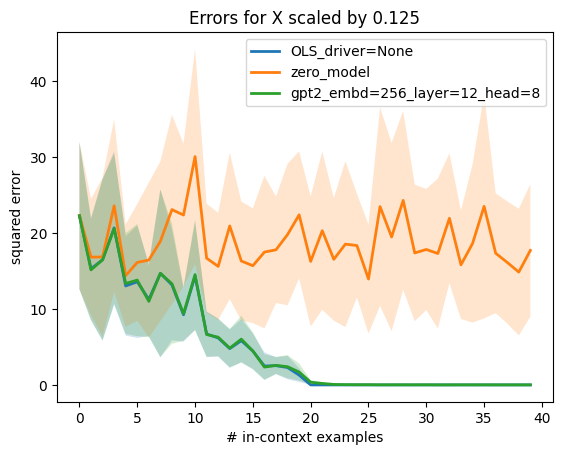

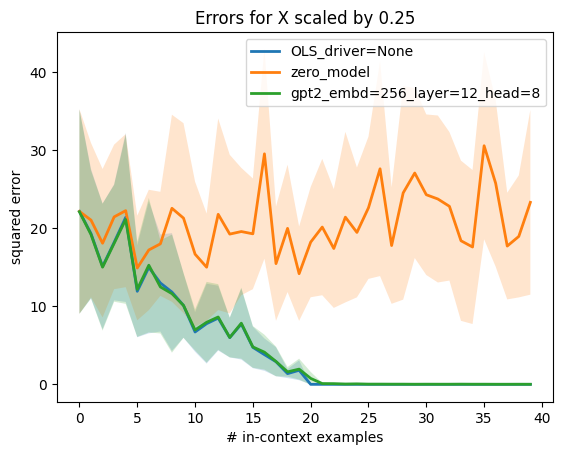

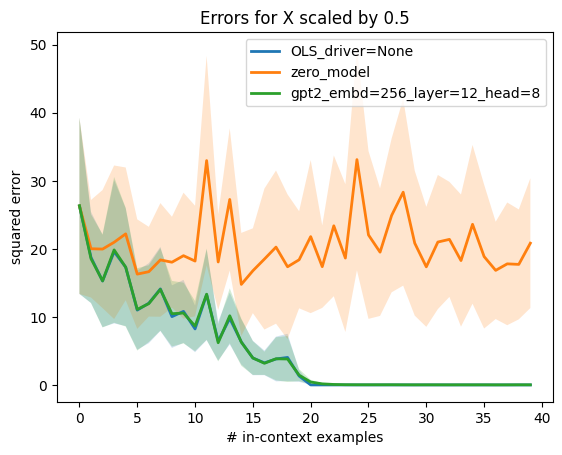

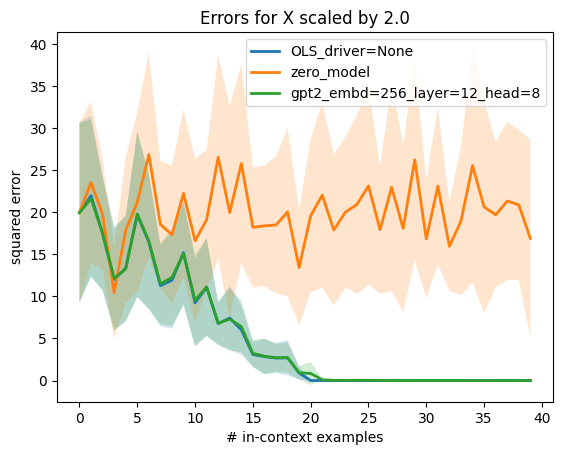

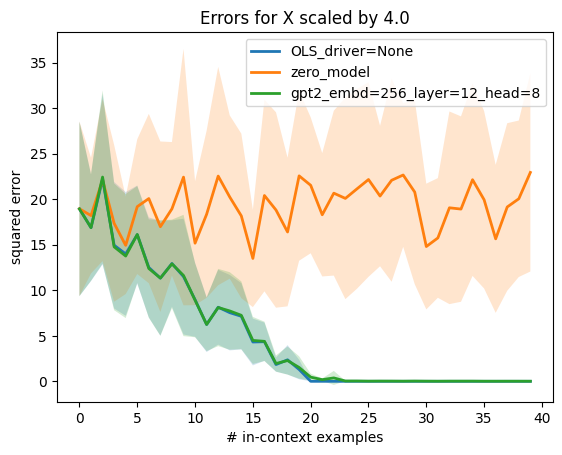

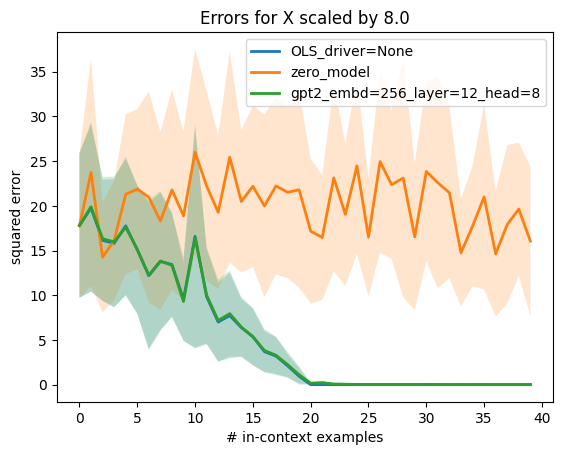

In [7]:
for b in scaled_in_benches:
    errs = b.evaluate(MODELS, num_batches=NUM_BATCHES)
    plot_model_errs(MODELS, errs)

    plt.title(f"Errors for X scaled by {b.function_class._scale}")  # pyright: ignore[reportAttributeAccessIssue]
    plt.legend()
    plt.show()

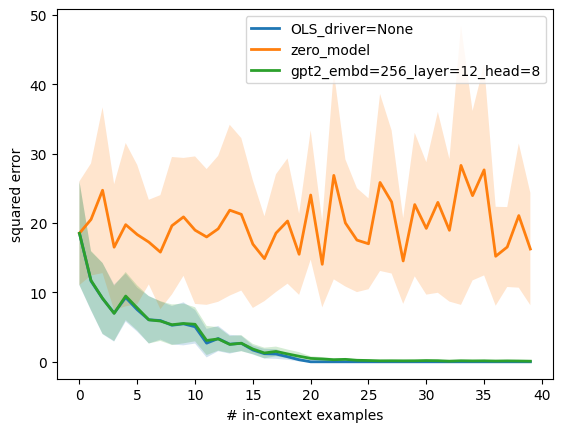

In [8]:
bench = FCErrorQuadrants(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=NUM_BATCHES)
plot_model_errs(MODELS, errs, plot_deviation=True)
plt.legend()

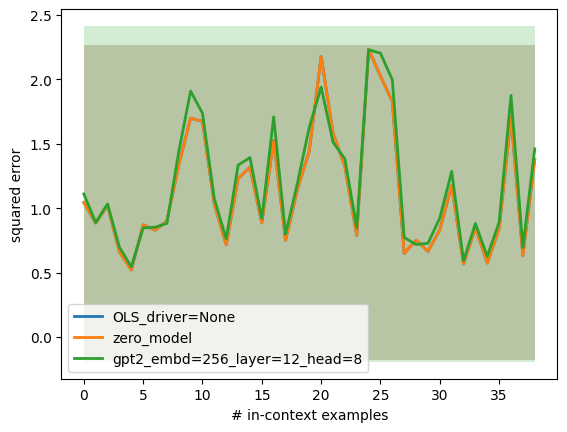

In [9]:
bench = FCErrorOrthogonal(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=NUM_BATCHES)

plot_model_errs(MODELS, errs)

plt.legend()
plt.show()

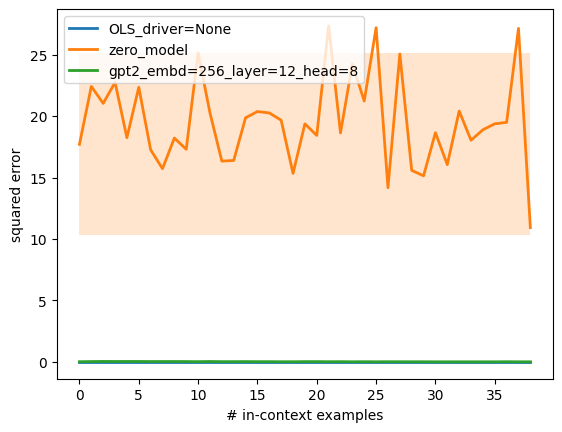

In [10]:
bench = FCErrorSeenPoints(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=NUM_BATCHES)

plot_model_errs(MODELS, errs)

plt.legend()
plt.show()